In [1]:
from datetime import datetime
print("This notebook is to test and demonstrate the spectral line fitting and file IO.\n"
	  "This version started 120324, last automatic datestamp:",datetime.now())

This notebook is to test and demonstrate the spectral line fitting and file IO.
This version started 120324, last automatic datestamp: 2024-12-04 12:21:56.543327


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import importlib, time, copy, os, sys, numpy as np, astropy.units as u
np.set_printoptions(linewidth=160)

from astropy.io import fits; import matplotlib.pyplot as plt; from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 20,'figure.figsize':[15,10],'image.origin':'lower'}) # Make the fonts big enough for papers

base_path = './'
sys.path.append(base_path)
from util import get_mask_errs, get_spice_err
from skew_correction import skew_correct, deskew_linefit_window
from linefit_leastsquares import fitter
from linefit_storage import linefits

/tmp/ipykernel_1071491/1317216178.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
linelist = {'Ar VIII+S III 700':700.3, 'O III 703':702.9, 'O III 704':703.9, 'Mg IX 706':706.0,
			'O II 718':718.5, 'S IV 745':744.9, 'S IV 748':748.4, 'S IV 750':750.2,
			'O V 759':758.7, 'S IV+O V 759':759.4, 'O V 760':760.3, 'O V 762':762.0,
			'N IV 765':765.1, 'Ne VIII 770':770.4, 'Mg VIII 772':772.3, 'Ne VIII 780':780.3,
			'S V 786':786.5, 'O IV 787':787.7, 'O IV 790':790.1, 'Ly Gamma 972':972.5,
			'C III 977':977.0, 'O I +- Na VI 989':988.7, 'N III 990':989.8, 'N III 992':991.6,
			'H I (+ O I) 1025':1025.7, 'O I 1027':1027.4, 'O VI 1032':1031.9, 'C II 1036':1036.5,
			'O VI 1037':1037.6}

line_names = list(linelist.keys())
line_waves = [linelist[name] for name in line_names]

In [4]:
spice_data_dir = './data' # Will need to update this to location of data file
spice_L2_filename = 'solo_L2_spice-n-ras_20220307T030536_V22_100663723-000.fits'
spice_L2_fullname = os.path.join(spice_data_dir, spice_L2_filename)
win_name = 'Ly Gamma 972 - Peak'

pxsz_mu = 18 # Platescale units below are Micron/Arcsecond for x & y, Micron/Angstrom for lambda
platescale_x, platescale_y, platescale_l = pxsz_mu/1.1, pxsz_mu/1.1, pxsz_mu/0.09
skew_bin_facs=[5,5] # How much to bin up data prior to interpolation/down after.
spice_sdev_guess = 0.1 # Initial guess for line width

hdul = fits.open(spice_L2_fullname)
hdul.info()
spice_dat, spice_hdr = hdul[win_name].data[0], hdul[win_name].header
spice_dat = spice_dat.transpose([2,1,0]).astype(np.float32)
hdul.close()

spice_dx, spice_dy, spice_dl = spice_hdr['CDELT1'],spice_hdr['CDELT2'],10*spice_hdr['CDELT3']
spice_wl0 = 10*spice_hdr['CRVAL3']-spice_dl*spice_hdr['CRPIX3']
spice_la = spice_wl0+spice_dl*np.arange(spice_dat.shape[2],dtype=np.float64)
spice_wlcen0 = np.mean(spice_la) # get_overall_center(spice_la,spice_dat) # Estimate overall line center across image

# Parameters of skew correction:
xlshift, ylshift = 1.6626831549412866, -1.7115244726176873

Filename: /home/jplowman/research/solar-physics/data/spice/20220307/solo_L2_spice-n-ras_20220307T030536_V22_100663723-000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Mg IX 706 - Peak    1 PrimaryHDU     418   (128, 834, 50, 1)   float32   
  1  O II 718 - Peak    1 ImageHDU       417   (128, 834, 50, 1)   float32   
  2  Ne VIII 770 / Mg VIII 772 (Merged)    1 ImageHDU       424   (128, 834, 66, 1)   float32   
  3  S V 786 / O IV 787 - Extend    1 ImageHDU       426   (128, 834, 58, 1)   float32   
  4  Ly Gamma 972 - Peak    1 ImageHDU       417   (128, 834, 36, 1)   float32   
  5  C III 977 (Merged)    1 ImageHDU       426   (128, 834, 42, 1)   float32   
  6  O VI 1032 - Peak    1 ImageHDU       417   (128, 834, 34, 1)   float32   
  7  VARIABLE_KEYWORDS    1 BinTableHDU    398   1R x 28C   [128D, 128I, 128I, 128I, 128I, 128I, 128E, 128E, 128E, 128E, 4I, 4I, 4I, 4I, 4J, 4J, 4J, 4J, 2944A, 128D, 128D, 50D, 50D, 66D, 58D, 36D, 42D, 34D]   
  8  WCSDVARR  

In [5]:
spicedat_skew = skew_correct(spice_dat, xlshift, ylshift, spice_dx, spice_dy, spice_dl, spice_wl0, 
							 lambdas=spice_la, lcen=np.mean(spice_la), skew_bin_facs=skew_bin_facs)
spiceerr_skew = get_spice_err(spicedat_skew,spice_hdr)
spice_skew_fit_mask, spice_skew_fit_err = get_mask_errs(spicedat_skew, None, error_cube=spiceerr_skew)

Estimating error for LW detector, index 1


In [6]:
fit_results = fitter(spicedat_skew, spiceerr_skew, spice_la, spice_skew_fit_mask, 
					 line_waves, spice_sdev_guess, line_names, cenbound_fac=0.0)
spice_fits, fit_errs, data_names, data_types, data_units, param_names = fit_results

Fitting  ['Ly Gamma 972']
0 of 128 fraction of lines fit = 0.8848920863309353
16 of 128 fraction of lines fit = 0.8848920863309353
32 of 128 fraction of lines fit = 0.8848920863309353
48 of 128 fraction of lines fit = 0.8848920863309353
64 of 128 fraction of lines fit = 0.8848920863309353
80 of 128 fraction of lines fit = 0.8836930455635491
96 of 128 fraction of lines fit = 0.8836930455635491
112 of 128 fraction of lines fit = 0.8848920863309353
127 of 128 fraction of lines fit = 0.8836930455635491


In [7]:
window_skewed = linefits([[spice_fits, fit_errs, data_names, data_types, data_units, param_names, spice_hdr]])

In [8]:
window_deskewed = linefits()
for key in window_skewed: window_deskewed[key] = deskew_linefit_window(window_skewed[key], xlshift, ylshift, lcen=np.mean(spice_la))

In [32]:
window_deskewed['Ly Gamma 972 - Peak']['Ly Gamma 972']['amplitudes'].meta

XTENSION= 'IMAGE   '           / Written by IDL:  Sun Sep  8 18:48:52 2024      
BITPIX  =                  -32 / Real*4 (floating point)                        
NAXIS   =                    4 / Number of dimensions                           
NAXIS1  =                  128 / Number of slit positions (x)                   
NAXIS2  =                  834 / Number of pixels along slit (y)                
NAXIS3  =                    1 / Number of pixels in dispersion dimension       
NAXIS4  =                    1 / Number of exposures per slit position (time)   
PCOUNT  =                    0 /  number of random group parameters             
GCOUNT  =                    1 /  number of random groups                       
DATE    = '2024-09-08T18:48:52' / Date and time of FITS file creation           
                                                                                
EXTNAME = 'Ly Gamma 972 - Peak' / Extension name                                
FILENAME= 'solo_L2_spice-n-r

Window name:  Ly Gamma 972 - Peak ; line:  Ly Gamma 972


[Text(0.5, 1.0, 'Fit Amplitude Uncertainties')]

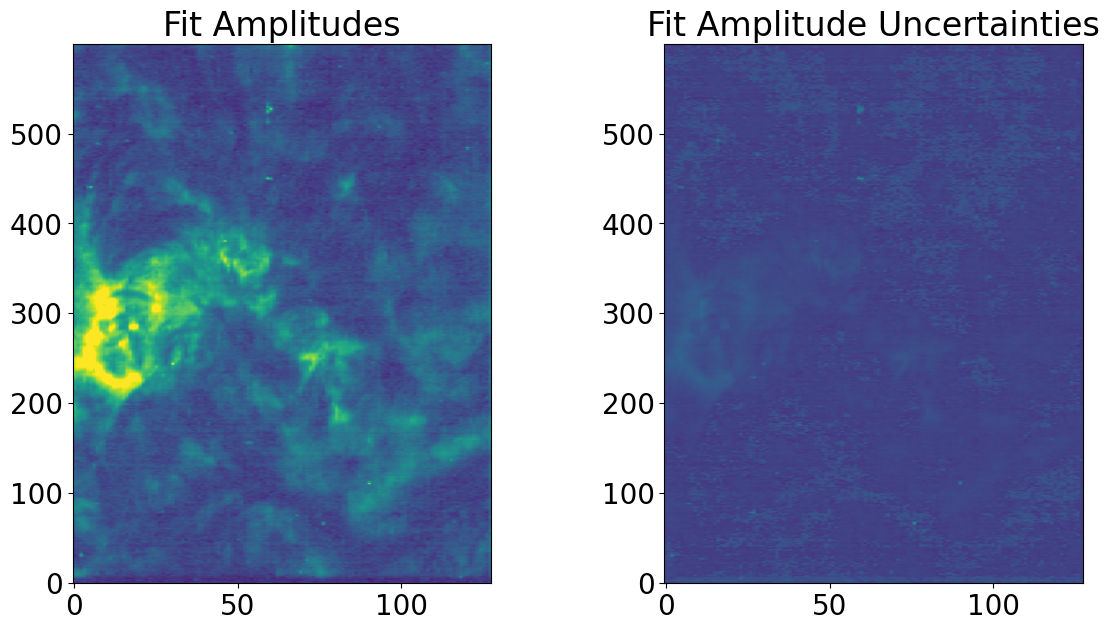

In [27]:
plt_line = list(window_deskewed[win_name].keys())[0]
print('Window name: ',win_name,'; line: ',plt_line)

asp = spice_hdr['CDELT2']/spice_hdr['CDELT1']
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=[14,7])
ax[0].imshow(window_deskewed[win_name][plt_line]['amplitudes'].data.squeeze()[:,100:700].T**0.5,vmin=0,vmax=20**0.5,aspect=asp)
ax[0].set(title='Fit Amplitudes')
ax[1].imshow(window_deskewed[win_name][plt_line]['amplitudes'].uncertainty.array.squeeze()[:,100:700].T**0.5,vmin=0,vmax=2**0.5,aspect=asp)
ax[1].set(title='Fit Amplitude Uncertainties')

[Text(0.5, 1.0, 'Fit Continuum Uncertainty')]

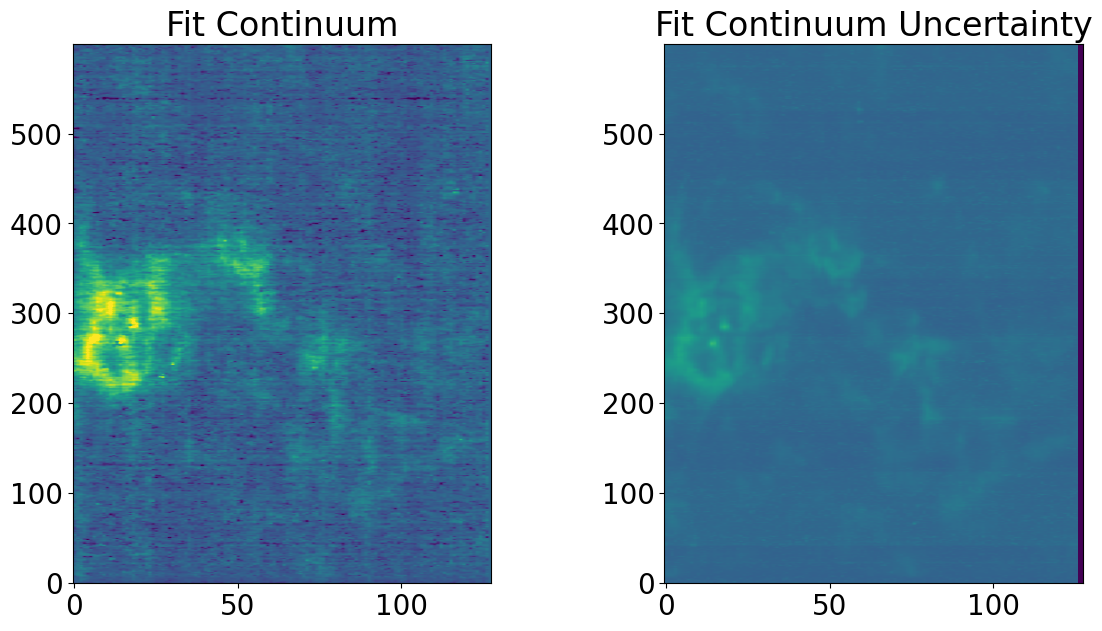

In [28]:
asp = spice_hdr['CDELT2']/spice_hdr['CDELT1']
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=[14,7])
ax[0].imshow(window_deskewed[win_name]['BACKGROUND']['continuum'].data.squeeze()[:,100:700].T,vmin=-1,vmax=2,aspect=asp)
ax[0].set(title='Fit Continuum')
ax[1].imshow(window_deskewed[win_name]['BACKGROUND']['continuum'].uncertainty.array.squeeze()[:,100:700].T,vmin=0,vmax=.1,aspect=asp)
ax[1].set(title='Fit Continuum Uncertainty')

In [11]:
window_skewed.save('../test_skewed.fits')

In [12]:
window_deskewed.save('../test_deskewed.fits')

In [13]:
window_deskewed_fromfile = linefits(filename='../test_deskewed.fits')

In [14]:
window_deskewed_fromfile[0].keys()

dict_keys(['Ly Gamma 972', 'BACKGROUND', 'CHI2'])

In [29]:
hdul = fits.open('../test_deskewed.fits')
hdul.info()
hdul.close()

Filename: ../test_deskewed.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Ly Gamma 972 - Peak Ly Gamma 972 amplitudes    1 PrimaryHDU     419   (128, 834, 1, 1)   float64   
  1  Ly Gamma 972 - Peak Ly Gamma 972 amplitudes ERRORS    1 ImageHDU       421   (128, 834, 1, 1)   float64   
  2  Ly Gamma 972 - Peak Ly Gamma 972 centers    1 ImageHDU       420   (128, 834, 1, 1)   float64   
  3  Ly Gamma 972 - Peak Ly Gamma 972 centers ERRORS    1 ImageHDU       421   (128, 834, 1, 1)   float64   
  4  Ly Gamma 972 - Peak Ly Gamma 972 sigmas    1 ImageHDU       420   (128, 834, 1, 1)   float64   
  5  Ly Gamma 972 - Peak Ly Gamma 972 sigmas ERRORS    1 ImageHDU       421   (128, 834, 1, 1)   float64   
  6  Ly Gamma 972 - Peak BACKGROUND continuum    1 ImageHDU       420   (128, 834, 1, 1)   float64   
  7  Ly Gamma 972 - Peak BACKGROUND continuum ERRORS    1 ImageHDU       421   (128, 834, 1, 1)   float64   
  8  Ly Gamma 972 - Peak CHI2 chi2    1 ImageHDU       420